
# Run every session

Google drive containing weights/etc.
https://drive.google.com/drive/folders/1hxMYwv69C_SJ6l1PgPa643xrr3SRZTmy?usp=sharing

In [ ]:
#accessed sheets data directly using technique as specified:
#https://medium.com/analytics-vidhya/colab-and-google-sheets-surprisingly-powerful-combination-for-data-science-part-1-bbbb11cbd8e

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime, timedelta
from IPython.core import display as ICD #use with ICD.display(dataframe) to show multiple
import os
import pickle
import csv
import shutil  
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1GImf6ZeF8ZeDv-F_lAbObzPNSLfNTACD4zP0u82eLqY/edit#gid=595628091')
sheet = wb.worksheet('ground_truth')
data = sheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]
for x in range(df.shape[1]):
  df[df.columns[x]] = df[df.columns[x]].apply(lambda y: '0' if y == '' else y)
new_df_schema = {
    'BUSIND_ID':df['BUSIND_ID'].astype(int),
    'DATETIME':(df['FISCAL_DATE'].astype(str)+" "+ df['PERIOD_ID'].astype(str)).apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S')),
    'GROUND_TRUTH':df['GROUND_TRUTH'].astype(float)
}
dff = pd.DataFrame(new_df_schema)

Extracting dates

In [ ]:
dff['DOW'] = dff.DATETIME.apply(lambda x: x.isoweekday())
dff['TIME'] = dff.DATETIME.dt.time
dff['DOY'] = dff.DATETIME.dt.dayofyear
dff['DAYSEC'] = dff.DATETIME.apply(lambda x: (x-x.replace(hour=0, minute=0, second=0)).seconds)
dff['nTIME'] = dff.DAYSEC/(24*60*60)
dff['nDOW'] = dff.DOW/7
dff['nDOY'] = dff.DATETIME.dt.dayofyear/(365+dff.DATETIME.dt.is_leap_year)  
dff['sinDOY'] = np.sin(2*np.pi*dff.nDOY)
dff['cosDOY'] = np.cos(2*np.pi*dff.nDOY)
dff['sinTIME'] = np.sin(2*np.pi*dff.nTIME)
dff['cosTIME'] = np.cos(2*np.pi*dff.nTIME)
dffs = dff.sort_values(by='DATETIME')
dffsi = dffs.set_index(np.arange(len(dffs)))

###Filling missing data with 0

Two cases:
1. Missing data => there is a 0 then.
2. Missing data => NaN.
We use case 1.

In [ ]:
blank_slate = pd.date_range(start = datetime.strptime('2015-01-01 00:00:00','%Y-%m-%d %H:%M:%S'), end = datetime.strptime('2018-12-31 23:45:00','%Y-%m-%d %H:%M:%S'), freq = '15min' )
bs = pd.DataFrame(blank_slate)
bs.index+=1
BS = bs.rename({0:'DATETIME'}, axis='columns')
dff.index-=1
df_a = dff.sort_values(by='DATETIME')
dffa = df_a.set_index(np.arange(len(df_a)))
df_b=pd.DataFrame(index=dffa.DATETIME.unique())
df_c=dffa.copy()
df_c.index=df_c.DATETIME
for i in range(1,6,1):
  df_b["GT"+str(i)]=df_c[df_c['BUSIND_ID']==i].GROUND_TRUTH
  #check
for i in range(1,6,1):
  df_b['nDOW'] = df_c[df_c['BUSIND_ID']==i].nDOW
  df_b['nTIME']= df_c[df_c['BUSIND_ID']==i].nTIME
  df_b['sinTIME']= df_c[df_c['BUSIND_ID']==i].sinTIME
  #/check
df_d = df_b.drop(['nDOW', 'nTIME', 'sinTIME'], axis=1)
df_d_normal =(df_d-df_d.min())/(df_d.max()-df_d.min())
minimum = df_d.min()
maximum = df_d.max()
BS.index=BS.DATETIME

In [ ]:
BS['DOW'] = BS.DATETIME.apply(lambda x: x.isoweekday())
BS['TIME'] = BS.DATETIME.dt.time
BS['DOY'] = BS.DATETIME.dt.dayofyear
BS['DAYSEC'] = BS.DATETIME.apply(lambda x: (x-x.replace(hour=0, minute=0, second=0)).seconds)
BS['nTIME'] = BS.DAYSEC/(24*60*60)
BS['nDOW'] = BS.DOW/7
BS['nDOY'] = BS.DATETIME.dt.dayofyear/(365+BS.DATETIME.dt.is_leap_year)  
BS['sinDOY'] = np.sin(2*np.pi*BS.nDOY)
BS['cosDOY'] = np.cos(2*np.pi*BS.nDOY)
BS['sinTIME'] = np.sin(2*np.pi*BS.nTIME)
BS['cosTIME'] = np.cos(2*np.pi*BS.nTIME)

In [ ]:
BS_datetime = BS.drop(['DOW', 'TIME', 'DOY', 'DAYSEC', 'cosDOY', 'cosTIME'], axis=1)
BS = BS.drop(['DATETIME', 'DOW', 'TIME', 'DOY', 'DAYSEC', 'cosDOY', 'cosTIME'], axis=1)
DATA = df_d_normal.join(BS, how='outer')
DATA_datetime = df_d_normal.join(BS_datetime, how='outer')

In [ ]:
DATA_datetime

,GT1,GT2,GT3,GT4,GT5,DATETIME,nTIME,nDOW,nDOY,sinDOY,sinTIME
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:00:00,0.000000,0.571429,0.00274,1.721336e-02,0.000000
2015-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:15:00,0.010417,0.571429,0.00274,1.721336e-02,0.065403
2015-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:30:00,0.020833,0.571429,0.00274,1.721336e-02,0.130526
2015-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:45:00,0.031250,0.571429,0.00274,1.721336e-02,0.195090
2015-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,2015-01-01 01:00:00,0.041667,0.571429,0.00274,1.721336e-02,0.258819
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 22:45:00,NaN,NaN,NaN,NaN,NaN,2018-12-31 22:45:00,0.947917,0.142857,1.00000,-2.449294e-16,-0.321439
2018-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,2018-12-31 23:00:00,0.958333,0.142857,1.00000,-2.449294e-16,-0.258819
2018-12-31 23:15:00,NaN,NaN,NaN,NaN,NaN,2018-12-31 23:15:00,0.968750,0.142857,1.00000,-2.449294e-16,-0.195090
2018-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,2018-12-31 23:30:00,0.979167,0.142857,1.00000,-2.449294e-16,-0.130526


In [ ]:
#we take a value from our data
from random import randrange

indexesused = [len(DATA)]
for a in range(3):
  a = True
  #24 hours * 4 * 31 (every 15 minutes for a month)
  while (a):
    i = randrange(0,len(DATA) - (24*4*31), 96)
    #we make sure that our values will not overlap
    if not any([( abs(i-x)<24*4*31) for x in indexesused]):
      a= False
      indexesused.append(i)
indexesused.remove(len(DATA))
DATA.set_index(np.arange(len(DATA)))
validation = pd.DataFrame(index = np.arange(len(DATA)), columns = DATA.columns)
test = pd.DataFrame(index = np.arange(len(DATA)), columns = DATA.columns)
training = DATA.copy(deep=True)

In [ ]:
DATA.set_index(np.arange(len(DATA)), inplace=True)
for i, x in enumerate(indexesused):
  if i<len(indexesused)*2/3:
    #print('a', x)
    validation.iloc[validation.index[x: x+31*(4*24)]] = DATA.iloc[x:x+31*(4*24)]
  else:
    #print('b', x)
    test.iloc[validation.index[x: x+31*(4*24)]] = DATA.iloc[x:x+31*(4*24)]
for x in sorted(indexesused, reverse=True):
  training.drop(training.index[range(x,x+(24*31*4))], axis='index', inplace=True)

In [ ]:
training

,GT1,GT2,GT3,GT4,GT5,nTIME,nDOW,nDOY,sinDOY,sinTIME
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.000000,0.571429,0.00274,1.721336e-02,0.000000
2015-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,0.010417,0.571429,0.00274,1.721336e-02,0.065403
2015-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,0.020833,0.571429,0.00274,1.721336e-02,0.130526
2015-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,0.031250,0.571429,0.00274,1.721336e-02,0.195090
2015-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,0.041667,0.571429,0.00274,1.721336e-02,0.258819
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 22:45:00,NaN,NaN,NaN,NaN,NaN,0.947917,0.142857,1.00000,-2.449294e-16,-0.321439
2018-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,0.958333,0.142857,1.00000,-2.449294e-16,-0.258819
2018-12-31 23:15:00,NaN,NaN,NaN,NaN,NaN,0.968750,0.142857,1.00000,-2.449294e-16,-0.195090
2018-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,0.979167,0.142857,1.00000,-2.449294e-16,-0.130526


In [ ]:
x_numpyt = training.to_numpy()
y_numpyt = training.drop(['nTIME', 'nDOW', 'sinTIME', 'sinDOY', 'nDOY'], axis = 1).to_numpy()
x_numpyv = validation.to_numpy()
y_numpyv = validation.drop([ 'nTIME', 'nDOW',  'sinTIME', 'sinDOY', 'nDOY'], axis = 1).to_numpy()
x_numpyte = test.to_numpy()
y_numpyte = test.drop(['nTIME', 'nDOW',  'sinTIME', 'sinDOY', 'nDOY'], axis = 1).to_numpy()
x_numpyt[x_numpyt!=x_numpyt] = 0
y_numpyt[y_numpyt!=y_numpyt] = 0
x_numpyv[x_numpyv!=x_numpyv] = 0
y_numpyv[y_numpyv!=y_numpyv] = 0
x_numpyte[x_numpyte!=x_numpyte] = 0
y_numpyte[y_numpyte!=y_numpyte] = 0
conced = np.concatenate([np.arange(indexesused[0], indexesused[0]+(24*30*4)), np.arange(indexesused[1], indexesused[1]+(24*30*4))])
x_numpyv = x_numpyv[conced]
y_numpyv = y_numpyv[conced]
x_numpyte = x_numpyte [np.arange(indexesused[2],indexesused[2] + 24*4*30)]
y_numpyte = y_numpyte [np.arange(indexesused[2],indexesused[2] + 24*4*30)]

In [ ]:
print(len(x_numpyt))
print(len(x_numpyte))
print(len(y_numpyv))
print(len(x_numpyt)+len(x_numpyte)+len(y_numpyv))
print(len(BS))

131328
2880
5760
139968
140256


# Models

In [ ]:
tf.__version__

'2.2.0'

## Model 3

not normalized data, first real iteration

In [ ]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (50, 50, 32)              4352      
_________________________________________________________________
dense_7 (Dense)              (50, 50, 5)               165       
Total params: 4,517
Trainable params: 4,517
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#If a RNN is stateful, it needs to know its batch size. Specify the batch size of your input tensors: 
#- If using a Sequential model, specify the batch size by passing a `batch_input_shape` argument to your first layer.
#- If using the functional API, specify the batch size by passing a `batch_shape` argument to your Input layer.

In [ ]:

tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(keras.Input(batch_shape=(10, 50, 5)))
model.add(keras.layers.LSTM(32,  return_sequences=True, stateful=True))
model.add(keras.layers.Dense(5, activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

model.fit(np.array([ training_y[j:j+50] for j in range(0,500,50)]) ,
          np.array([training_y[j+1:j+51] for j in range(0,500,50)]), 
          batch_size=None, epochs=10000,verbose=0)

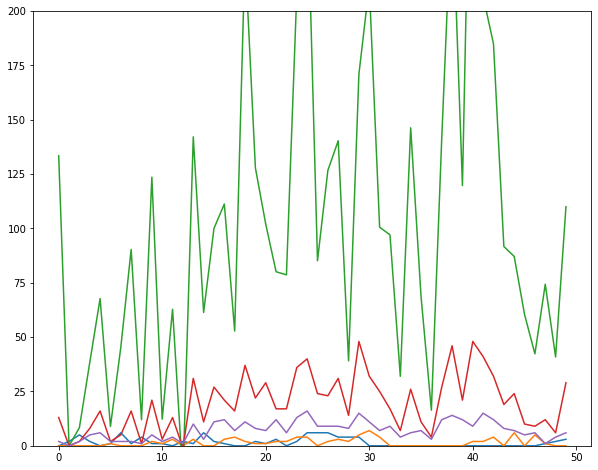

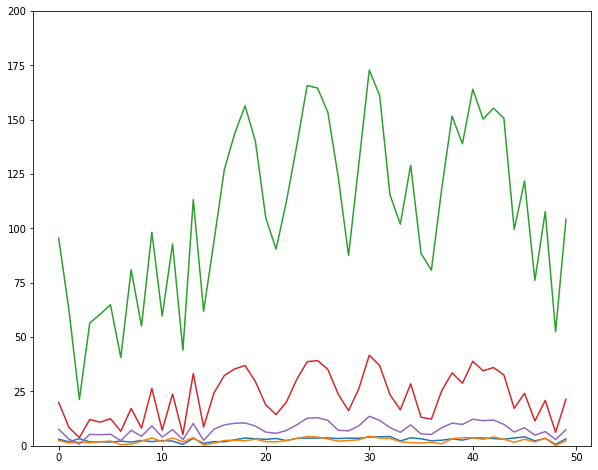

In [ ]:
plt.plot(training_y[1:51])
plt.ylim(0,200)
plt.show()
plt.plot(model.predict(x=np.array([[i for i in training_y[:50]],]*10))[0])
plt.ylim(0,200)
plt.show()


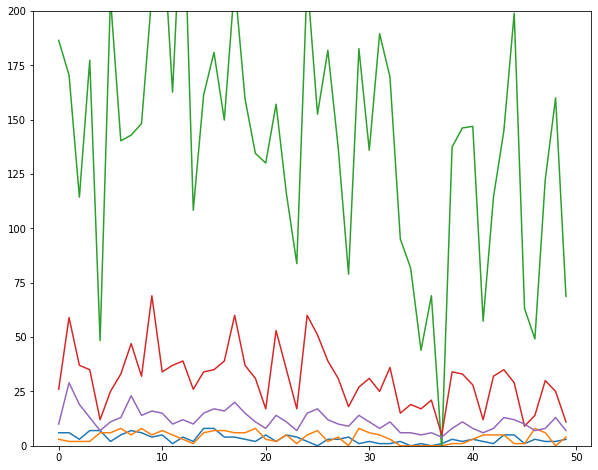

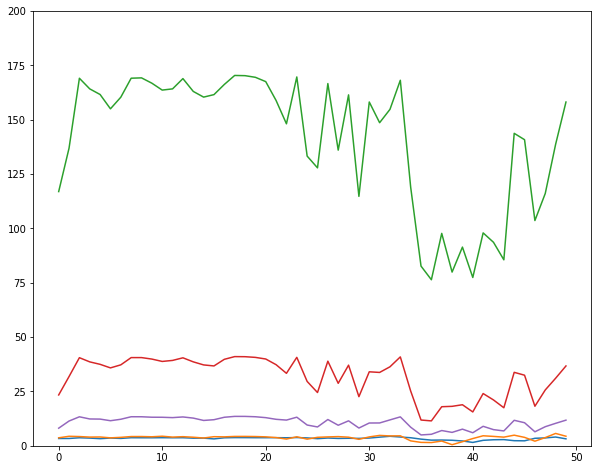

In [ ]:
plt.plot(training_y[1001:1051])
plt.ylim(0,200)
plt.show()
plt.plot(model.predict(x=np.array([[i for i in training_y[1000:1050]],]*10))[0])
plt.ylim(0,200)
plt.show()


In [ ]:
#sb debug2
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(keras.Input(batch_shape=(2, 50, 5)))
model.add(keras.layers.LSTM(32,  return_sequences=True, stateful=True))
model.add(keras.layers.Dense(5, activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

model.fit(np.array([ training_y[j:j+50] for j in range(0,5000,50)]) ,
          np.array([training_y[j+1:j+51] for j in range(0,5000,50)]), 
          batch_size=2, epochs=100,verbose=0)

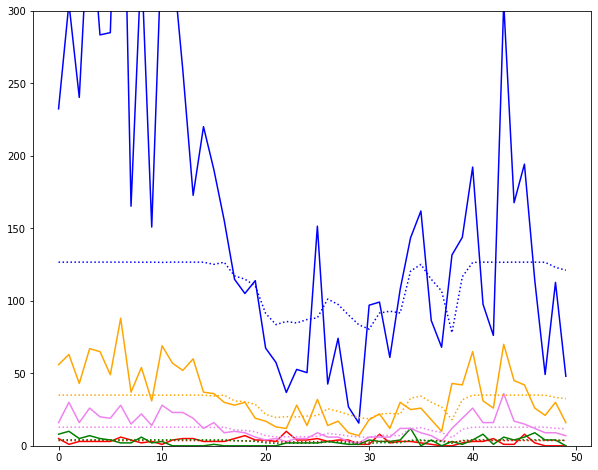

In [ ]:
for i in range(5):
  plt.plot(training_y[10001:10051,i],c=['r','g','b','orange','violet'][i])

for i in range(5):
  plt.plot(model.predict(x=np.array([[i for i in training_y[10000:10050]],]*2))[0,:,i],
           color=['r','g','b','orange','violet'][i],
           ls=':')

plt.ylim(0,300)
plt.show()

In [ ]:
print(model.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (1, 200, 32)              4352      
_________________________________________________________________
dense_21 (Dense)             (1, 200, 5)               165       
Total params: 4,517
Trainable params: 4,517
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')



## Model 4: vanilla lstm

In [ ]:
print(model4.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (10, 80, 32)              5248      
_________________________________________________________________
dense (Dense)                (10, 80, 8)               264       
Total params: 5,512
Trainable params: 5,512
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
tf.keras.backend.clear_session()

model4 = tf.keras.Sequential()
model4.add(keras.Input(batch_shape=(10, 50, 8)))
model4.add(keras.layers.LSTM(32,  return_sequences=True, stateful=True))
model4.add(keras.layers.Dense(5, activation='relu'))
model4.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

model4.fit(np.array([x_numpyt[j:j+50] for j in range(0,10000,50)]) ,
          np.array([y_numpyt[j+24:j+74] for j in range(0,10000,50)]), 
          batch_size=10, epochs=1,verbose=0)

In [ ]:
tf.keras.backend.clear_session()

model4 = tf.keras.Sequential()
model4.add(keras.Input(batch_shape=(10, 50, 8)))
model4.add(keras.layers.LSTM(32,  return_sequences=True, stateful=True))
model4.add(keras.layers.Dense(5, activation='relu'))
model4.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

model4.fit(np.array([x_numpyt[j:j+50] for j in range(0,10000,50)]) ,
          np.array([y_numpyt[j+96:j+50+96] for j in range(0,10000,50)]), 
          batch_size=10, epochs=1,verbose=0)

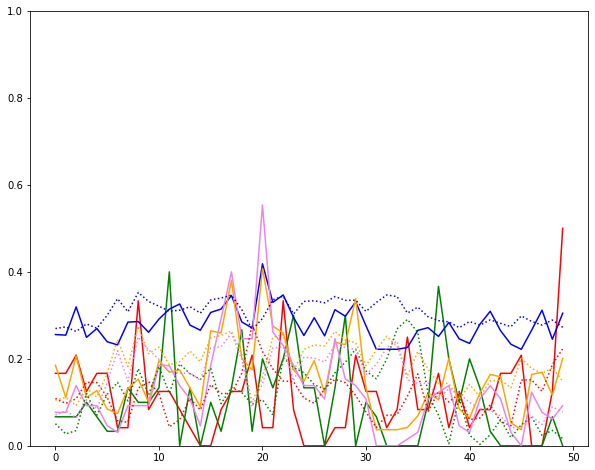

In [ ]:
for i in range(5):
  plt.plot(x_numpydf1[10024:10074,i],c=['r','g','b','orange','violet'][i])

for i in range(5):
  plt.plot(model4.predict(x=np.array([[i for i in x_numpydf1[10000:10050]],]*10))[0,:,i],
           color=['r','g','b','orange','violet'][i],
           ls=':')

plt.ylim(0,1)
plt.show()

In [ ]:
npx_test = np.array([x_numpyt[j:j+50] for j in range(0,10000,96*2)]).reshape

(53, 50, 8)

In [ ]:
tf.keras.backend.clear_session()

model4 = tf.keras.Sequential()
model4.add(keras.Input(batch_shape=(10, 50, 8)))
model4.add(keras.layers.LSTM(32,  return_sequences=True, stateful=True))
model4.add(keras.layers.Dense(5, activation='relu'))
model4.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

history = model4.fit(np.array([x_numpyt[j:j+50] for j in range(0,10000,50)]) ,
          np.array([y_numpyt[j+96:j+50+96] for j in range(0,10000,50)]), 
          batch_size=10, epochs=1,verbose=0)

In [ ]:
batches = [2,4, 8, 16, 32, 64]
lstm_shape = [32, 64, 128]
epoch = 50
timesteps = 96
n_xfeatures = x_numpyt.shape[-1]
n_yfeatures = y_numpyt.shape[-1]
times = {}
for p in batches:
  for o in lstm_shape:
    
    tf.keras.backend.clear_session()
    model4 = tf.keras.Sequential()
    model4.add(keras.Input(batch_shape=(p, timesteps, n_xfeatures)))
    model4.add(keras.layers.LSTM(o,  return_sequences=True, stateful=True))
    model4.add(keras.layers.Dense(5, activation='relu'))
    model4.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
#np.array([y_numpydf1[j+24:j+74] for j in range(0,10000,50)])
    x_batches = np.array([x_numpyt[0:2**8*timesteps]]).reshape((-1,timesteps,n_xfeatures))
    y_batches = np.array([y_numpyt[timesteps:2**8*timesteps+timesteps]]).reshape((-1,timesteps,n_yfeatures))
    x_valbatches = np.array( x_numpyv[0:timesteps*p]).reshape((-1,timesteps,n_xfeatures))
    y_valbatches = np.array( y_numpyv[timesteps:timesteps*(p+1)]).reshape((-1,timesteps,n_yfeatures))
    x_valbatches = np.array(x_valbatches.tolist()*p)
    y_valbatches = np.array(y_valbatches.tolist()*p)
    start_time = time.time()
    history = model4.fit( x_batches, y_batches, 
              batch_size=p, epochs=epoch,verbose=0,
              validation_data = (x_valbatches,y_valbatches),
              callbacks=[early_stopping]
                          )
    model4.save('saved_model4/my_model'+str(p)+'-'+str(o))
    hist_file_name = 'history-'+str(p)+'-'+str(o)
    times['time-'+'history'+str(p)+'-'+str(o)] = (time.time() - start_time)
    with open('saved_model4/'+hist_file_name, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)
    if os.path.exists('saved_model4/'+hist_file_name):
      print('saved_model4/'+hist_file_name, 'successfully saved')
    with open('saved_model4/times', 'wb') as file_pi:
      pickle.dump(times, file_pi)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model4/my_model2-32/assets
saved_model4/history-2-32 successfully saved
INFO:tensorflow:Assets written to: saved_model4/my_model2-64/assets
saved_model4/history-2-64 successfully saved
INFO:tensorflow:Assets written to: saved_model4/my_model2-128/assets
saved_model4/history-2-128 successfully saved
INFO:tensorflow:Assets written to: saved_model4/my_model4-32/assets
saved_model4/history-4-32 successfully saved
INFO:tensorflow:Assets written to: saved_model4/my_model4-64/assets
saved_model4/history-4-64 successfully saved
INFO:tensorflow:Assets written to: saved_model4/my_model4-128/assets
saved_model4/history-4-128 successfully saved
INFO:tensorflow:Assets written to: saved_model4/my_model8-32/assets
saved_model4/history-8-32 successfully saved
INFO:tensorflow:Assets written to: saved_model4/my_model8-64/assets
saved_model4/history-8-64 successfully saved
INFO:tensor

In [ ]:
def print_history(file_path, acc = True, loss = True):
  with open(file_path, mode='r') as f:
    history = csv.reader(f)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
for p in batches:
  for o in lstm_shape:
    hist_file_name = 'history'+str(p)+'-'+str(o)+'.csv'
    print(hist_file_name)
    print_history('saved_model4/'+hist_file_name)

In [ ]:

def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()
    

## Model5 multilayer lstm

In [ ]:
print(model5.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (10, 50, 32)              5248      
_________________________________________________________________
lstm_1 (LSTM)                (10, 50, 32)              8320      
_________________________________________________________________
dense (Dense)                (10, 50, 5)               165       
Total params: 13,733
Trainable params: 13,733
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
tf.keras.backend.clear_session()
model5 = tf.keras.Sequential()
model5.add(keras.Input(batch_shape=(10, 50, 8)))
model5.add(keras.layers.LSTM(32,  return_sequences=True, stateful=True))
model5.add(keras.layers.LSTM(32,  return_sequences=True, stateful=True))
model5.add(keras.layers.Dense(5, activation='relu'))
model5.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

model5.fit(np.array([x_numpydf1[j:j+50] for j in range(0,20000,50)]) ,
          np.array([y_numpydf1[j+24:j+74] for j in range(0,20000,50)]), 
          batch_size=10, epochs=500,verbose=0)

In [ ]:
batches = [2,4, 8, 16, 32]
lstm_shape = [32, 64, 128]
epoch = 50
timesteps = 96
n_xfeatures = x_numpyt.shape[-1]
n_yfeatures = y_numpyt.shape[-1]
times = {}
for p in batches:
  for o in lstm_shape:
    tf.keras.backend.clear_session()
    model5 = tf.keras.Sequential()
    model5.add(keras.Input(batch_shape=(p, timesteps, n_xfeatures))) 
    model5.add(keras.layers.LSTM(o,  return_sequences=True, stateful=True))
    model5.add(keras.layers.LSTM(o,  return_sequences=True, stateful=True))
    model5.add(keras.layers.Dense(5, activation='relu'))
    model5.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    x_batches = np.array([x_numpyt[0:2**8*timesteps]]).reshape((-1,timesteps,n_xfeatures))
    y_batches = np.array([y_numpyt[timesteps:2**8*timesteps+timesteps]]).reshape((-1,timesteps,n_yfeatures))
    x_valbatches = np.array( x_numpyv[0:timesteps*p]).reshape((-1,timesteps,n_xfeatures))
    y_valbatches = np.array( y_numpyv[timesteps:timesteps*(p+1)]).reshape((-1,timesteps,n_yfeatures))
    x_valbatches = np.array(x_valbatches.tolist()*p)
    y_valbatches = np.array(y_valbatches.tolist()*p)
    start_time = time.time()
    history = model5.fit( x_batches, y_batches, 
              batch_size=p, epochs=epoch,verbose=0,
              validation_data = (x_valbatches,y_valbatches),
              callbacks=[early_stopping]
                          )
    model5.save('saved_model5/my_model'+str(p)+'-'+str(o))
    hist_file_name = 'history-'+str(p)+'-'+str(o)
    times['time-'+'history'+str(p)+'-'+str(o)] = (time.time() - start_time)
    with open('saved_model5/'+hist_file_name, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)
    if os.path.exists('saved_model5/'+hist_file_name):
      print('saved_model5/'+hist_file_name, 'successfully saved')
    with open('saved_model5/times', 'wb') as file_pi:
      pickle.dump(times, file_pi)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model5/my_model2-32/assets
saved_model5/history-2-32 successfully saved
INFO:tensorflow:Assets written to: saved_model5/my_model2-64/assets
saved_model5/history-2-64 successfully saved
INFO:tensorflow:Assets written to: saved_model5/my_model2-128/assets
saved_model5/history-2-128 successfully saved
INFO:tensorflow:Assets written to: saved_model5/my_model4-32/assets
saved_model5/history-4-32 successfully saved
INFO:tensorflow:Assets written to: saved_model5/my_model4-64/assets
saved_model5/history-4-64 successfully saved
INFO:tensorflow:Assets written to: saved_model5/my_model4-128/assets
saved_model5/history-4-128 successfully saved
INFO:tensorflow:Assets written to: saved_model5/my_model8-32/assets
saved_model5/history-8-32 successfully saved
INFO:tensorflow:Assets written to: saved_model5/my_model8-64/assets
saved_model5/history-8-64 successfully saved
INFO:tensor

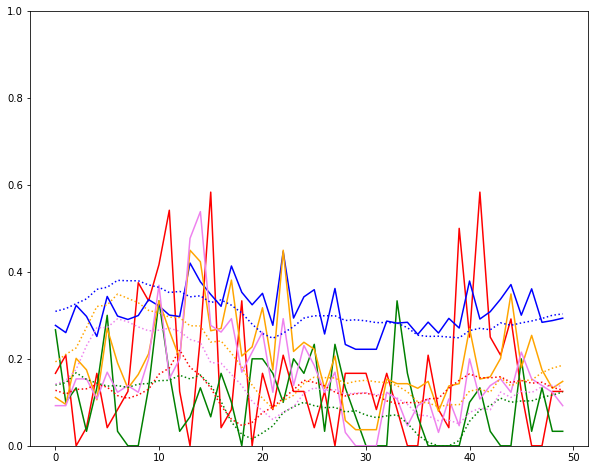

In [ ]:
for i in range(5):
  plt.plot(x_numpydf1[30024:30074,i],c=['r','g','b','orange','violet'][i])

for i in range(5):
  plt.plot(model5.predict(x=np.array([[i for i in x_numpydf1[30000:30050]],]*10))[0,:,i],
           color=['r','g','b','orange','violet'][i],
           ls=':')

plt.ylim(0,1)
plt.show()

## Checking best model via hyper parameters

In [ ]:
batches = [2,4, 8, 16, 32]
lstm_shape = [32, 64, 128]
epoch = 50
timesteps = 96
n_xfeatures = x_numpyt.shape[-1]
n_yfeatures = y_numpyt.shape[-1]

###saving model

In [ ]:
def save_model(model_number):
  os.mkdir('/content/gdrive/My Drive/Colab Notebooks/'+'saved_model'+str(model_number)+'/')
  for p in batches:
    for o in lstm_shape:
      with open('/content/gdrive/My Drive/Colab Notebooks/'+'saved_model'+str(model_number)+'/my_model'+str(p)+'-'+str(o)+'.txt', 'w+') as f:
        f.write('saved_model'+str(model_number)+'/my_model'+str(p)+'-'+str(o))

###testing models

In [ ]:
accuracy5 = {}
load_test_model(5, accuracy5)

In [ ]:
model_path = '/content/gdrive/My Drive/Colab Notebooks/'+'saved_model'+str(5)+'/tensorflowsave/my_model'+str(2)+'-'+str(32)
model = keras.models.load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (2, 96, 32)               5248      
_________________________________________________________________
dense (Dense)                (2, 96, 5)                165       
Total params: 5,413
Trainable params: 5,413
Non-trainable params: 0
_________________________________________________________________


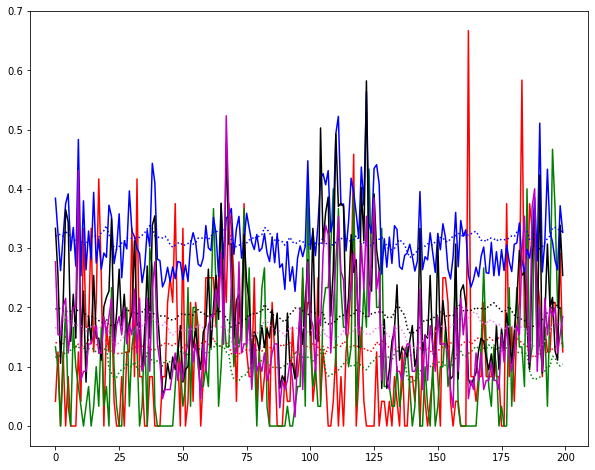

In [ ]:
for i in range(5):
  plt.plot(accuracy5['2-32-preds'][1,:200,i],ls=':',c=['r','g','b','k','violet'][i]) 
  plt.plot(y_numpyte[timesteps:2**4*timesteps+timesteps].reshape((2,-1,5))[1,:200,i],c=['r','g','b','k','m'][i]) 
plt.show()

In [ ]:
accuracy4 = {}  
load_test_model(4, accuracy4)

In [ ]:
def get_accuracy(dict_scores, correct_scores, stds, calc_rms=False):
  for p in batches:
    for o in lstm_shape:
      predicted_scores = dict_scores.get(str(p)+'-'+str(o)+'-preds')
      # print(predicted_scores.shape)
      # print(correct_scores[timesteps:2**4*timesteps+timesteps].reshape((p,-1,5)).shape)
      mean = np.mean((predicted_scores - correct_scores[timesteps:2**4*timesteps+timesteps].reshape(predicted_scores.shape)), axis=(0,1), dtype=float)
      std = np.std(predicted_scores- correct_scores[timesteps:2**4*timesteps+timesteps].reshape(predicted_scores.shape), axis=(0,1), dtype=float)
      if calc_rms:
        rms = np.mean( (predicted_scores- correct_scores[timesteps:2**4*timesteps+timesteps].reshape(predicted_scores.shape))**2, axis=(0,1), dtype=float)**0.5
      # print((str(p)+'-'+str(o)))
      if calc_rms:
        stds.append( (str(p)+'-'+str(o),std, mean,rms))
      else:
        stds.append( (str(p)+'-'+str(o),std, mean))

In [ ]:
std4r = []
get_accuracy(accuracy4, y_numpyte, std4r,calc_rms=True)

In [ ]:
std5r = []
get_accuracy(accuracy5, y_numpyte, std5r, calc_rms=True)

In [ ]:
names4 = [std4r[i][0] for i in range(len(std4r))]
stds4 = [std4r[i][1] for i in range(len(std4r))]
means4 = [std4r[i][2] for i in range(len(std4r))]
rms4 = [std4r[i][3] for i in range(len(std4r))]

In [ ]:
names5 = [std5r[i][0] for i in range(len(std5r))]
stds5 = [std5r[i][1] for i in range(len(std5r))]
means5 = [std5r[i][2] for i in range(len(std5r))]
rms5 = [std5r[i][3] for i in range(len(std5r))]

In [ ]:
np.min(np.sqrt(np.array(stds4)**2))

0.05107083600439913

In [ ]:
y_means=np.mean(y_numpyt,axis=0)

In [ ]:
names4_mean = names4+['mean']
stds4_mean = stds4+[y_means]
rms4_mean = rms4+[y_means]

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/saved_model4/tensorflowsave/history-'+str(2)+'-'+str(32), 'rb') as handle:
    hista = pickle.load(handle)
    for x in hista:
      print(x)

loss
accuracy
val_loss
val_accuracy


In [ ]:
def get_dicts(p, o):
  with open('/content/gdrive/My Drive/Colab Notebooks/saved_model4/tensorflowsave/history-'+str(p)+'-'+str(o), 'rb') as handle:
      hista = pickle.load(handle)
      loss = hista['loss']
      val_err = hista['val_loss']
      fit_err = hista['accuracy']
      return loss, val_err, fit_err

In [ ]:
for p in batches:
  for o in lstm_shape:
    l, v, f = get_dicts(p,o)
    print(len(l), len(v), len(f))

In [ ]:
plt.figure(figsize=(16,10))
index = 0
for I, p in enumerate(batches):
  for J, o in enumerate(lstm_shape):
    index+=1
    l, v, f = get_dicts(p,o)
    x_labels = np.arange(1, len(v)+1)
    ax=plt.subplot(len(batches),len(lstm_shape),index)
    ax.set_title('history-'+str(p)+'-'+str(o))
    ax.plot(x_labels, l, c='b')
    ax.plot(x_labels, v, c='r')
    ax.set_ylabel('Loss, Validation Accuracy')
    # ax1=ax.twinx()
    ax.set_ylim(bottom=.005, top=.02)
    # ax1.set_ylim(bottom=.5, top=1)
    # ax1.plot(x_labels, f,c='lawngreen')
    # ax1.set_ylabel('Fit Accuracy')
plt.figlegend(labels = (  'loss', 'validation loss'), loc='best')
plt.tight_layout(pad=1.2)
plt.show()

NameError: ignored

<Figure size 1152x720 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


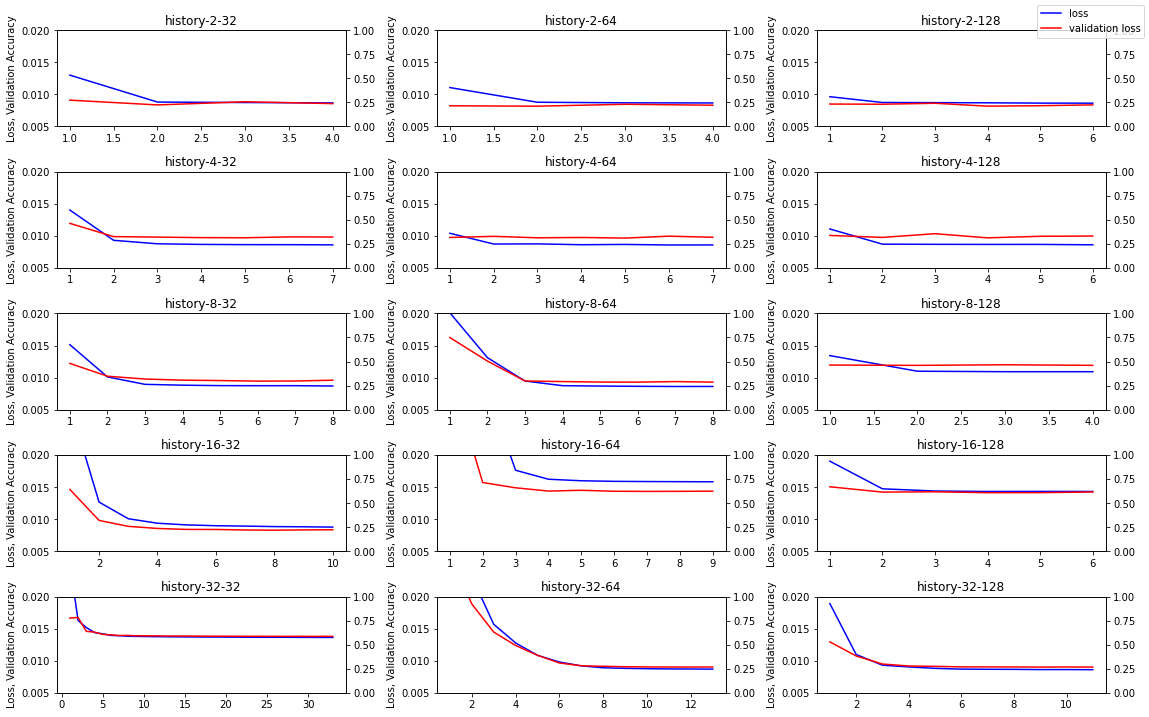

In [ ]:
plt.figure(figsize=(16,10))
index = 0
for I, p in enumerate(batches):
  for J, o in enumerate(lstm_shape):
    index+=1
    l, v, f = get_dicts(p,o)
    x_labels = np.arange(1, len(v)+1)
    ax=plt.subplot(len(batches),len(lstm_shape),index)
    ax.set_title('history-'+str(p)+'-'+str(o))
    ax.plot(x_labels, l, c='b')
    ax.plot(x_labels, v, c='r')
    ax.set_ylabel('Loss, Validation Accuracy')
    # ax1=ax.twinx()
    ax.set_ylim(bottom=.005, top=.02)
    # ax1.set_ylim(bottom=.5, top=1)
    # ax1.plot(x_labels, f,c='lawngreen')
    # ax1.set_ylabel('Fit Accuracy')
plt.figlegend(labels = (  'loss', 'validation loss'), loc='best')
plt.tight_layout(pad=1.2)
plt.show()

In [ ]:
def get_dicts5(p, o):
  with open('/content/gdrive/My Drive/Colab Notebooks/saved_model5/tensorflowsave/history-'+str(p)+'-'+str(o), 'rb') as handle:
      hista = pickle.load(handle)
      loss = hista['loss']
      val_err = hista['val_loss']
      fit_err = hista['accuracy']
      return loss, val_err, fit_err

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


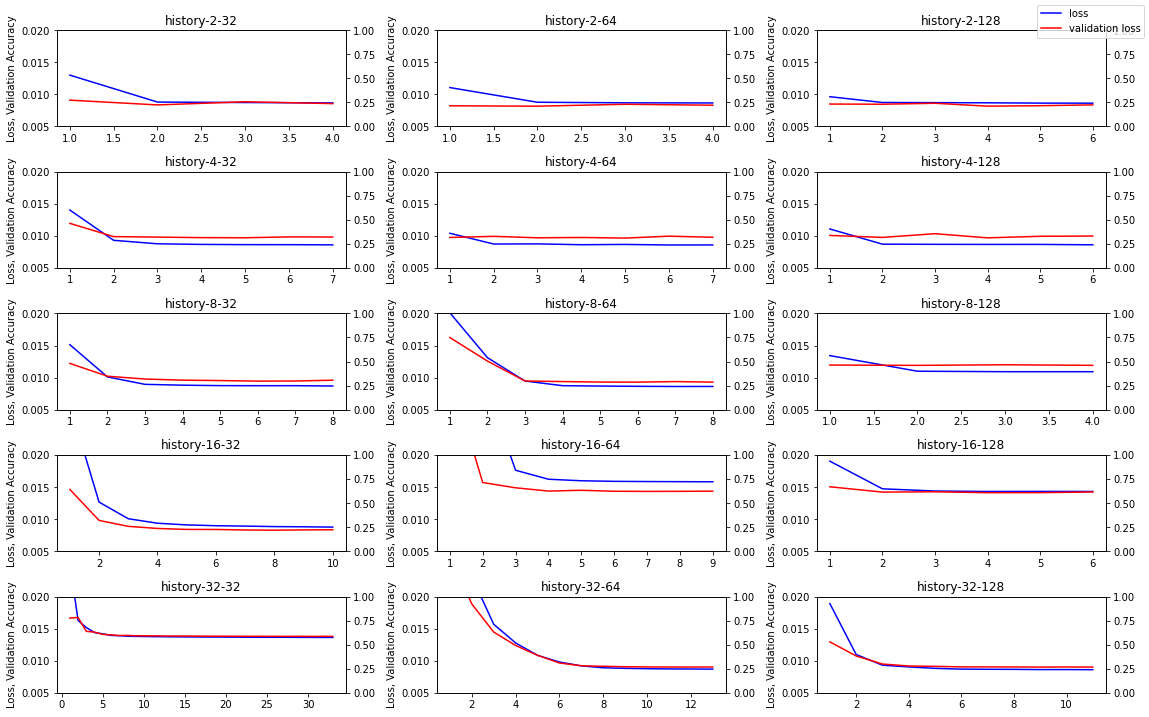

In [ ]:
plt.figure(figsize=(16,10))
index = 0
for I, p in enumerate(batches):
  for J, o in enumerate(lstm_shape):
    index+=1
    l, v, f = get_dicts5(p,o)
    x_labels = np.arange(1, len(v)+1)
    ax=plt.subplot(len(batches),len(lstm_shape),index)
    ax.set_title('history-'+str(p)+'-'+str(o))
    ax.plot(x_labels, l, c='b')
    ax.plot(x_labels, v, c='r')
    ax.set_ylabel('Loss, Validation Accuracy')
    # ax1=ax.twinx()
    ax.set_ylim(bottom=.005, top=.02)
    # ax1.set_ylim(bottom=.5, top=1)
    # ax1.plot(x_labels, f,c='lawngreen')
    # ax1.set_ylabel('Fit Accuracy')
plt.figlegend(labels = (  'loss', 'validation loss'), loc='best')
plt.tight_layout(pad=1.2)
plt.show()

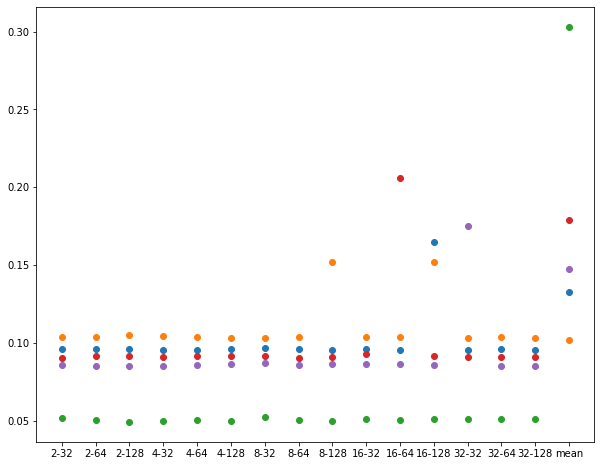

In [ ]:
 [plt.scatter(names4_mean, i, 
            #  c=[	'red',	'orangered',	'gold',	'yellow',	'lawngreen',	'green',	
            #     'turquoise',	'deepskyblue',	'cornflowerblue',	'mediumblue',	'navy',	
            #     'mediumslateblue',	'darkviolet',	'fuchsia', 'black','gray'	]
             ) for i in np.array(rms4_mean).T]
# [plt.scatter(names4, i, 
#              c=[	'red',	'orangered',	'gold',	'yellow',	'lawngreen',	'green',	'turquoise',	'deepskyblue',	'cornflowerblue',	'mediumblue',	'navy',	'mediumslateblue',	'darkviolet',	'fuchsia', 'black'	]) for i in np.array(means4).T]
plt.show()

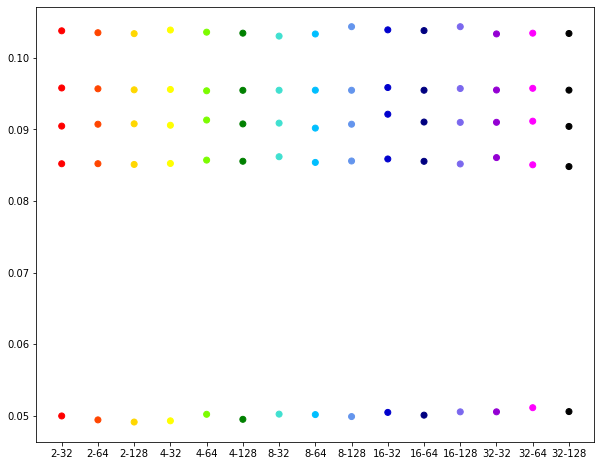

In [ ]:
[plt.scatter(names5, i, 
             c=[	'red',	'orangered',	'gold',	'yellow',	'lawngreen',	'green',	'turquoise',	'deepskyblue',	'cornflowerblue',	'mediumblue',	'navy',	'mediumslateblue',	'darkviolet',	'fuchsia', 'black']) for i in np.array(stds5).T]
# [plt.scatter(names4, i, 
#              c=[	'red',	'orangered',	'gold',	'yellow',	'lawngreen',	'green',	'turquoise',	'deepskyblue',	'cornflowerblue',	'mediumblue',	'navy',	'mediumslateblue',	'darkviolet',	'fuchsia', 'black'	]) for i in np.array(means4).T]
plt.show()

##Changing Data

In [ ]:
batches = [2,4, 8, 16, 32]
lstm_shape = [32, 64, 128]
epoch = 50
timesteps = 96
n_xfeatures = x_numpyt.shape[-1]
n_yfeatures = y_numpyt.shape[-1]

In [ ]:
normalized_df1_extended['pTIME'] = normalized_df1_extended['nTIME']

In [ ]:
normalized_df1_extended.pTIME = normalized_df1_extended.pTIME.shift(-96)

In [ ]:
#we take a value from our data
from random import randrange

indexesused = [len(normalized_df1_extended)]
for a in range(64*3):
  a = True
  #24 hours * 4 (every 15 minutes) * 5 possible values.0
  while (a):
    i = randrange(len(normalized_df1_extended) - (24*4*2))
    #we make sure that our values will not overlap
    if not any([( abs(i-x)<24*4*2) for x in indexesused]):
      a= False
      indexesused.append(i)
indexesused.remove(len(normalized_df1_extended))
normalized_df1_extended.set_index(np.arange(len(normalized_df1_extended)))
validation = pd.DataFrame(index = np.arange(len(normalized_df1_extended)), columns = normalized_df1_extended.columns)
test = pd.DataFrame(index = np.arange(len(normalized_df1_extended)), columns = normalized_df1_extended.columns)
training = normalized_df1_extended.copy(deep=True)

In [ ]:
normalized_df1_extended.head()

,GT1,GT2,GT3,GT4,GT5,nDOW,nTIME,sinTIME
2015-01-01 09:00:00,0.000000,0.0,0.239547,0.100529,0.030769,0.000008,0.074074,0.914836
2015-01-01 09:15:00,0.000000,0.0,0.307771,0.105820,0.030769,0.000008,0.092593,0.889241
2015-01-01 09:30:00,0.083333,0.0,0.221971,0.037037,0.000000,0.000008,0.111111,0.862133
2015-01-01 09:45:00,0.208333,0.0,0.227335,0.047619,0.030769,0.000008,0.129630,0.833628
2015-01-01 10:00:00,0.083333,0.0,0.246569,0.079365,0.076923,0.000008,0.148148,0.803848


In [ ]:
test.head()

,GT1,GT2,GT3,GT4,GT5,DOW,nTIME,nDOY,sinDOY,sinTIME
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [ ]:
DATA

,GT1,GT2,GT3,GT4,GT5,DOW,nTIME,nDOY,sinDOY,sinTIME
0,NaN,NaN,NaN,NaN,NaN,0.00274,0.000000,0.00274,1.721336e-02,0.000000
1,NaN,NaN,NaN,NaN,NaN,0.00274,0.010417,0.00274,1.721336e-02,0.065403
2,NaN,NaN,NaN,NaN,NaN,0.00274,0.020833,0.00274,1.721336e-02,0.130526
3,NaN,NaN,NaN,NaN,NaN,0.00274,0.031250,0.00274,1.721336e-02,0.195090
4,NaN,NaN,NaN,NaN,NaN,0.00274,0.041667,0.00274,1.721336e-02,0.258819
...,...,...,...,...,...,...,...,...,...,...
140251,NaN,NaN,NaN,NaN,NaN,1.00000,0.947917,1.00000,-2.449294e-16,-0.321439
140252,NaN,NaN,NaN,NaN,NaN,1.00000,0.958333,1.00000,-2.449294e-16,-0.258819
140253,NaN,NaN,NaN,NaN,NaN,1.00000,0.968750,1.00000,-2.449294e-16,-0.195090
140254,NaN,NaN,NaN,NaN,NaN,1.00000,0.979167,1.00000,-2.449294e-16,-0.130526


In [ ]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/saved_model5-2/times

'/content/gdrive/My Drive/Colab Notebooks/saved_model5-2/times'


In [ ]:
def get_dicts5_2(p, o):
  with open('/content/drive/My Drive/Colab Notebooks/saved_model5-2/history-'+str(p)+'-'+str(o), 'rb') as handle:
      hista = pickle.load(handle)
      loss = hista['loss']
      val_err = hista['val_loss']
      fit_err = hista['accuracy']
      return loss, val_err, fit_err

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


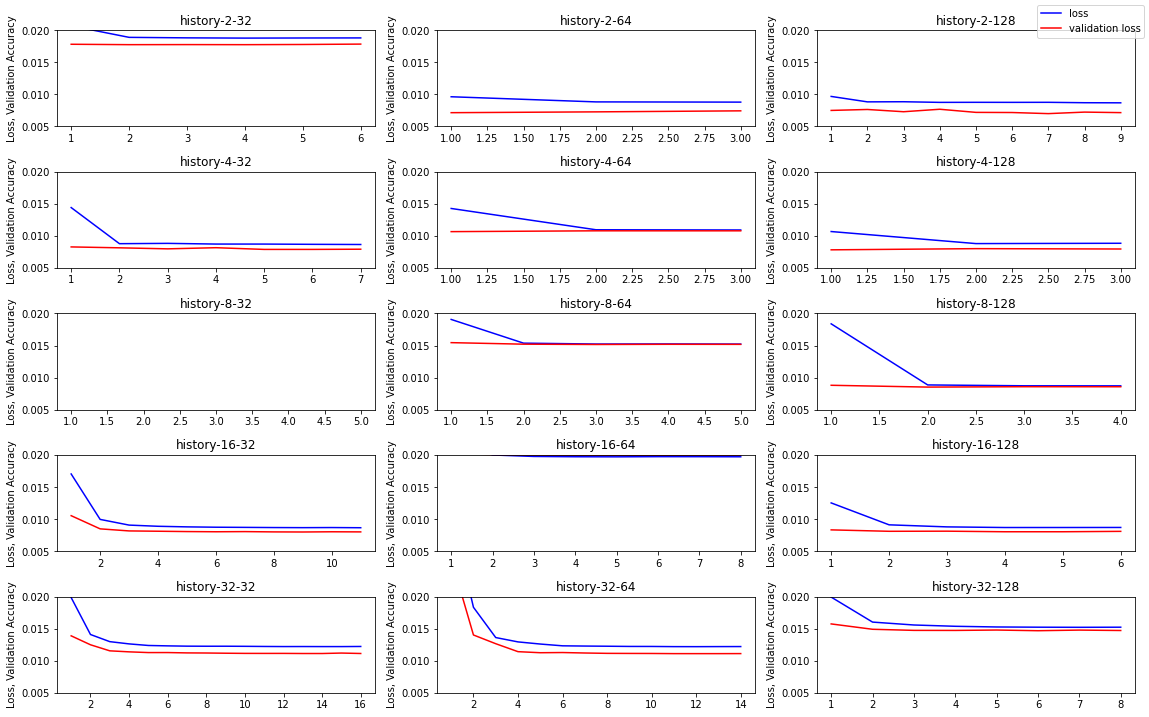

In [ ]:
plt.figure(figsize=(16,10))
index = 0
for I, p in enumerate(batches):
  for J, o in enumerate(lstm_shape):
    index+=1
    l, v, f = get_dicts5_2(p,o)
    x_labels = np.arange(1, len(v)+1)
    ax=plt.subplot(len(batches),len(lstm_shape),index)
    ax.set_title('history-'+str(p)+'-'+str(o))
    ax.plot(x_labels, l, c='b')
    ax.plot(x_labels, v, c='r')
    ax.set_ylabel('Loss, Validation Accuracy')
    # ax1=ax.twinx()
    ax.set_ylim(bottom=.005, top=.02)
    # ax1.set_ylim(bottom=.5, top=1)
    # ax1.plot(x_labels, f,c='lawngreen')
    # ax1.set_ylabel('Fit Accuracy')
plt.figlegend(labels = (  'loss', 'validation loss'), loc='best')
plt.tight_layout(pad=1.2)
plt.show()

Note: 8-32 has loss in the range of 0.03

In [ ]:
def get_dicts6(p, o, l):
  with open('/content/drive/My Drive/Colab Notebooks/saved_model6/history-'+str(p)+'-'+str(o)+'-'+str(l), 'rb') as handle:
      hista = pickle.load(handle)
      loss = hista['loss']
      val_err = hista['val_loss']
      fit_err = hista['accuracy']
      return loss, val_err, fit_err

In [ ]:
plt.figure(figsize=(16,10))
index = 0
for I, p in enumerate(batches):
  for J, o in enumerate(lstm_shape):
    for l in lstm_shape2:
      index+=1
      l, v, f = get_dicts6(p,o,l)
      x_labels = np.arange(1, len(v)+1)
      ax=plt.subplot(len(batches),len(lstm_shape)+len(lstm_shape2),index)
      ax.set_title('history-'+str(p)+'-'+str(o)+'-'+str(l))
      ax.plot(x_labels, l, c='b')
      ax.plot(x_labels, v, c='r')
      ax.set_ylabel('Loss, Validation Accuracy')
      # ax1=ax.twinx()
      ax.set_ylim(bottom=.005, top=.02)
      # ax1.set_ylim(bottom=.5, top=1)
      # ax1.plot(x_labels, f,c='lawngreen')
      # ax1.set_ylabel('Fit Accuracy')
plt.figlegend(labels = (  'loss', 'validation loss'), loc='best')
plt.tight_layout(pad=1.2)
plt.show()

Assume missing data is 0, not NaN.

In [ ]:
batches = [2,4, 8, 16, 32]
lstm_shape = [32, 64, 128]
epoch = 70
timesteps = 96
n_xfeatures = x_numpyt.shape[-1]
n_yfeatures = y_numpyt.shape[-1]
times = {}
for p in batches:
  for o in lstm_shape:
    tf.keras.backend.clear_session()
    model7 = tf.keras.Sequential()
    model7.add(keras.Input(batch_shape=(p, timesteps, n_xfeatures))) 
    model7.add(keras.layers.LSTM(o,  return_sequences=True, stateful=True))
    model7.add(keras.layers.LSTM(o,  return_sequences=True, stateful=True))
    model7.add(keras.layers.Dense(5, activation='relu'))
    model7.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
    x_batches = np.array([x_numpyt[0:2**8*timesteps]]).reshape((-1,timesteps,n_xfeatures))
    y_batches = np.array([y_numpyt[timesteps:2**8*timesteps+timesteps]]).reshape((-1,timesteps,n_yfeatures))
    x_valbatches = np.array( x_numpyv[0:timesteps*p]).reshape((-1,timesteps,n_xfeatures))
    y_valbatches = np.array( y_numpyv[timesteps:timesteps*(p+1)]).reshape((-1,timesteps,n_yfeatures))
    x_valbatches = np.array(x_valbatches.tolist()*p)
    y_valbatches = np.array(y_valbatches.tolist()*p)
    start_time = time.time()
    history = model7.fit( x_batches, y_batches, 
              batch_size=p, epochs=epoch,verbose=0,
              validation_data = (x_valbatches,y_valbatches),
              callbacks=[early_stopping]
                          )
    model7.save('/content/gdrive/My Drive/Colab Notebooks/saved_model7-2/my_model'+str(p)+'-'+str(o))
    hist_file_name = 'history-'+str(p)+'-'+str(o)
    times['time-'+'history'+str(p)+'-'+str(o)] = (time.time() - start_time)
    with open('/content/gdrive/My Drive/Colab Notebooks/saved_model7-2/'+hist_file_name, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)
    if os.path.exists('/content/gdrive/My Drive/Colab Notebooks/saved_model7-2/'+hist_file_name):
      print('/content/gdrive/My Drive/Colab Notebooks/saved_model7-2/'+hist_file_name, 'successfully saved')
with open('/content/gdrive/My Drive/Colab Notebooks/saved_model7-2/times', 'wb') as file_pi:
  pickle.dump(times, file_pi)

In [ ]:
for s in range(len(y_numpyte)):
  if np.all(y_numpyte[s]!=np.zeros_like(s)):
    print(s)
    break

84


In [ ]:
batches = [2]
lstm_shape = [32, 64, 128]
lstm_shape2 = [0, 32, 64]
epoch = 40
timesteps = 96
n_xfeatures = x_numpyt.shape[-1]
n_yfeatures = y_numpyt.shape[-1]
times = {}
for p in batches:
  for o in lstm_shape:
    for l in lstm_shape2:
      layer1 = o
      layer2 = o+l
      layer3 = o+o+l
      tf.keras.backend.clear_session()
      model9 = tf.keras.Sequential()
      model9.add(keras.Input(batch_shape=(p, timesteps, n_xfeatures))) 
      model9.add(keras.layers.LSTM(layer1,  return_sequences=True, stateful=True))
      model9.add(keras.layers.LSTM(layer2,  return_sequences=True, stateful=True))
      model9.add(keras.layers.LSTM(layer3,  return_sequences=True, stateful=True))
      model9.add(keras.layers.Dense(5, activation='tanh'))
      model9.compile(optimizer='Adadelta', loss='mean_squared_error', metrics='accuracy')
      x_batches = np.array([x_numpyt[0:2**8*timesteps]]).reshape((-1,timesteps,n_xfeatures))
      y_batches = np.array([y_numpyt[timesteps:2**8*timesteps+timesteps]]).reshape((-1,timesteps,n_yfeatures))
      x_valbatches = np.array( x_numpyv[0:timesteps*p]).reshape((-1,timesteps,n_xfeatures))
      y_valbatches = np.array( y_numpyv[timesteps:timesteps*(p+1)]).reshape((-1,timesteps,n_yfeatures))
      x_valbatches = np.array(x_valbatches.tolist()*p)
      y_valbatches = np.array(y_valbatches.tolist()*p)
      start_time = time.time()
      history = model9.fit( x_batches, y_batches, 
                batch_size=p, epochs=epoch,verbose=0,
                validation_data = (x_valbatches,y_valbatches)
                            )
      model9.save('/content/drive/My Drive/Colab Notebooks/saved_model9/my_model'+str(p)+'-'+str(layer1)+'-'+str(layer2)+'-'+str(layer3))
      hist_file_name = 'history-'+str(p)+'-'+str(layer1)+'-'+str(layer2)+'-'+str(layer3)
      times['time-'+'history'+str(p)+'-'+str(layer1)+'-'+str(layer2)+'-'+str(layer3)] = (time.time() - start_time)
      with open('/content/drive/My Drive/Colab Notebooks/saved_model9/'+hist_file_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
      if os.path.exists('/content/drive/My Drive/Colab Notebooks/saved_model9/'+hist_file_name):
        print('/content/drive/My Drive/Colab Notebooks/saved_model9/'+hist_file_name, 'successfully saved')
with open('/content/drive/My Drive/Colab Notebooks/saved_model9/times.pickle', 'wb') as file_pi:
  pickle.dump(times, file_pi)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_model9/my_model2-32-32-64/assets
/content/drive/My Drive/Colab Notebooks/saved_model9/history-2-32-32-64 successfully saved
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_model9/my_model2-32-64-96/assets
/content/drive/My Drive/Colab Notebooks/saved_model9/history-2-32-64-96 successfully saved
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_model9/my_model2-32-96-128/assets
/content/drive/My Drive/Colab Notebooks/saved_model9/history-2-32-96-128 successfully saved


In [ ]:
BS_datetime

,DATETIME,nTIME,nDOW,nDOY,sinDOY,sinTIME
DATETIME,,,,,,
2015-01-01 00:00:00,2015-01-01 00:00:00,0.000000,0.571429,0.00274,1.721336e-02,0.000000
2015-01-01 00:15:00,2015-01-01 00:15:00,0.010417,0.571429,0.00274,1.721336e-02,0.065403
2015-01-01 00:30:00,2015-01-01 00:30:00,0.020833,0.571429,0.00274,1.721336e-02,0.130526
2015-01-01 00:45:00,2015-01-01 00:45:00,0.031250,0.571429,0.00274,1.721336e-02,0.195090
2015-01-01 01:00:00,2015-01-01 01:00:00,0.041667,0.571429,0.00274,1.721336e-02,0.258819
...,...,...,...,...,...,...
2018-12-31 22:45:00,2018-12-31 22:45:00,0.947917,0.142857,1.00000,-2.449294e-16,-0.321439
2018-12-31 23:00:00,2018-12-31 23:00:00,0.958333,0.142857,1.00000,-2.449294e-16,-0.258819
2018-12-31 23:15:00,2018-12-31 23:15:00,0.968750,0.142857,1.00000,-2.449294e-16,-0.195090


In [ ]:
tf.get_logger().setLevel('INFO')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

### current directory

In [ ]:
epoch = 30
timesteps = 96
n_xfeatures = x_numpyt.shape[-1]
n_yfeatures = y_numpyt.shape[-1]
times = {}

layer1 = 32
layer2 = 32
layer3 = 64
tf.keras.backend.clear_session()
p = 1

model10 = tf.keras.Sequential()
model10.add(keras.Input(batch_shape=(p, timesteps, n_xfeatures))) 
model10.add(keras.layers.LSTM(layer1,  return_sequences=True, stateful=True))
model10.add(keras.layers.LSTM(layer2,  return_sequences=True, stateful=True))
model10.add(keras.layers.LSTM(layer3,  return_sequences=True, stateful=True))
model10.add(keras.layers.Dense(5, activation='tanh'))
model10.compile(optimizer='Adadelta', loss='mean_squared_error', metrics='accuracy')
x_batches = np.array([x_numpyt[0:2**8*timesteps]]).reshape((-1,timesteps,n_xfeatures))
y_batches = np.array([y_numpyt[timesteps:2**8*timesteps+timesteps]]).reshape((-1,timesteps,n_yfeatures))
x_valbatches = np.array( x_numpyv[0:timesteps*p]).reshape((-1,timesteps,n_xfeatures))
y_valbatches = np.array( y_numpyv[timesteps:timesteps*(p+1)]).reshape((-1,timesteps,n_yfeatures))
x_valbatches = np.array(x_valbatches.tolist()*p)
y_valbatches = np.array(y_valbatches.tolist()*p)

start_time = time.time()
history = model10.fit( x_batches, y_batches, 
          batch_size=p, epochs=epoch,verbose=0,
          validation_data = (x_valbatches,y_valbatches)
                      )
model10.save('/content/gdrive/My Drive/Colab Notebooks/saved_model10/my_model'+str(p)+'-'+str(layer1)+'-'+str(layer2)+'-'+str(layer3))
hist_file_name = 'history-'+str(p)+'-'+str(layer1)+'-'+str(layer2)+'-'+str(layer3)
times['time-'+'history'+str(p)+'-'+str(layer1)+'-'+str(layer2)+'-'+str(layer3)] = (time.time() - start_time)
with open('/content/gdrive/My Drive/Colab Notebooks/saved_model10/'+hist_file_name, 'wb') as file_pi:
  pickle.dump(history.history, file_pi)
if os.path.exists('/content/gdrive/My Drive/Colab Notebooks/saved_model10/'+hist_file_name):
  print('/content/gdrive/My Drive/Colab Notebooks/saved_model10/'+hist_file_name, 'successfully saved')
with open('/content/gdrive/My Drive/Colab Notebooks/saved_model10/times.pickle', 'wb') as file_pi:
  pickle.dump(times, file_pi)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/saved_model10/my_model1-32-32-64/assets
/content/gdrive/My Drive/Colab Notebooks/saved_model10/history-1-32-32-64 successfully saved


In [ ]:
def leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
def update_data(x_input_datetime, y_output):
  '''x_input_datetime is the input which generated y_output (must still have datetime)
  returns the necessary information for the next iteration as well as the formatted next_x to feed into the network'''
  next_x_datetime = np.array(x_input_datetime)#np.array(x_input_datetime.shape[0],x_input_datetime.shape[1]+1, x_input_datetime.shape[2] )
  next_x_datetime[0:5]=y_output
  current_time = x_input_datetime[5]
  next_time = x_input_datetime[5] +timedelta(minutes=15)
  #datetime
  next_x_datetime[5] = next_time
  #nDOW
  next_x_datetime[6] = next_time.isoweekday()/7
  #nTIME
  next_x_datetime[7] = (next_time-next_time.replace(hour=0,minute=0, second=0)).seconds/(24*60*60)
  #nDOY
  next_x_datetime[8] = next_time.dayofyear /(365+leap_year(next_time.year))
  #sinDOY
  next_x_datetime[9] = np.sin(2*np.pi*next_x_datetime[8])
  #sinTIME
  next_x_datetime[10] =np.sin(next_x_datetime[7]*np.pi*2)
 
  next_x = np.delete(next_x_datetime, 5)
  
  return next_x_datetime, next_x

In [ ]:
x = DATA_datetime.iloc[indexesused[-1]:indexesused[-1]+96].to_numpy()
x[x!=x] = 0


In [ ]:
def test_model(Xs_datetime_big, cor_Ys, model_num, model_ver, length, model):
  Ys = None
  # print('Xs_datetime_big', Xs_datetime_big.shape)
  Xs_big = np.delete(Xs_datetime_big, 5, axis=1).astype(float)
  # print('Xs_big', Xs_big.shape)

  Xs_datetime = Xs_datetime_big[:][:][-1]
  # print('Xs_datetime', Xs_datetime.shape)
  for i in range(length):
    # print('loop', i)
    if i>0:
      # print('Xs_datetime', Xs_datetime.shape)#, Xs_datetime)
      # print('\nYs', Ys[:][-1][-1].shape)
      Xs_datetime, Xs = update_data(Xs_datetime, Ys[:][-1][-1])
      Xs_big = np.append(Xs_big[1:], [Xs], axis=0)
      # print('Xs_big.shape', Xs_big.shape)
    Ys = model.predict( np.array( [Xs_big.tolist(),]*1), verbose=0 )
    # Ys = model.predict( np.array( [Xs_big.tolist(),]*2), verbose=0 ) #use when batchsize = 2
    # print('Ys shape:', Ys.shape)
    # print('Ys no nans shape:', Ys[~np.isnan(Ys).any(axis=2)].shape)
  pred_Ys = np.array(Ys[-1][-length:])
  # print('pred_Ys', pred_Ys.shape)
  # print('cor_Ys', cor_Ys.shape)
  mse = ((pred_Ys - cor_Ys)**2).mean(axis=1)
  # print(mse)
  return mse, pred_Ys

In [ ]:
#pred shape is (96,5)
def next_data(preds, x_start):
  # print(preds[0],'\n', x_start[0])
  # full = np.zeros((x_start.shape), dtype=[('b1', 'f4'),('b2', 'f4'),('b3', 'f4'),('b4', 'f4'),('b5', 'f4'), ('time', 'datetime64[s]'), ('t1', 'f4'), ('t2', 'f4'), ('t3', 'f4'), ('t4', 'f4'), ('t5', 'f4')])
  # print('debug next_data:', preds.shape, x_start.shape)
  full = np.copy(x_start)
  # print('next_data preds.shape', preds.shape)
  # print('next_data x_start.shape', x_start.shape)
  full[-96:, 0:5] = preds
  # print(x_start[:, 6:].shape)
  # print(x_start[:,5:][0])
  # full[:,5:] = x_start[:,5:]
  # full = np.delete(full, 6, axis=1)
  # print('next_data full', full.shape)
  # print('next_data full[-96:]', full[-96:].shape)
  # print(full[0])
  return full#[-96:]

In [ ]:
modelpath = '/content/drive/My Drive/Colab Notebooks/saved_model'+str(10)+'/'+'my_model1-32-32-64'
model = keras.models.load_model(modelpath)

In [ ]:
for i in range(29):
  x = DATA_datetime.iloc[indexesused[-1]+96*i:indexesused[-1]+96*(i+1)].to_numpy()
  # print(x.shape)
  # print(type(x))
  x[x!=x] = 0
  # print(i)
  if i==0:
    mse, pred = test_model( x, y_numpyte[96:96*2], '10', 'my_model1-32-32-64', 96, model)
    # print(pred.shape)

  else:
    #make next batch for pred
    pred_x= next_data(pred, x)
    # print('pred_x', pred_x.shape)
    print('pred_x', pred_x.shape)
    # print('i', i, '\ny_numpyte[(i+1)*96:(i+2)*96]', y_numpyte[(i+1)*96:(i+2)*96].shape)
    mse, pred = test_model( pred_x, y_numpyte[(i+1)*96:(i+2)*96], '10', 'my_model1-32-32-64', 96, model)
  with open('/content/drive/My Drive/Colab Notebooks/saved_model10/my_model1-32-32-64/predictions-day-test-'+str(i+1)+'.pickle', 'wb') as f:
    pickle.dump(pred, f)
  with open('/content/drive/My Drive/Colab Notebooks/saved_model10/my_model1-32-32-64/mse-test'+str(i+1)+'.pickle', 'wb') as f:
    pickle.dump(mse, f)

next_data preds.shape (96, 5)
next_data x_start.shape (96, 11)
next_data full (96, 11)
next_data full[-96:] (96, 11)
pred_x (96, 11)
next_data preds.shape (96, 5)
next_data x_start.shape (96, 11)
next_data full (96, 11)
next_data full[-96:] (96, 11)
pred_x (96, 11)
next_data preds.shape (96, 5)
next_data x_start.shape (96, 11)
next_data full (96, 11)
next_data full[-96:] (96, 11)
pred_x (96, 11)


KeyboardInterrupt: ignored

In [ ]:
a=0
for i in range(29):
  with open('/content/drive/My Drive/Colab Notebooks/saved_model10/my_model1-32-32-64/mse'+str(i+1)+'.pickle', 'rb') as f:
      hista = pickle.load(f)
      a+=np.sum(hista)
print(a)

32.00243116252292


In [ ]:
timesteps = 96
n_xfeatures = x_numpyt.shape[-1]

In [ ]:
def get_dicts8(p, o, i):
  with open('/content/gdrive/My Drive/Colab Notebooks/saved_model8/history-'+str(p)+'-'+str(o)+'-'+str(o+i)+'-'+str(o+o+i), 'rb') as handle:
      hista = pickle.load(handle)
      loss = hista['loss']
      val_err = hista['val_loss']
      fit_err = hista['accuracy']
      return loss, val_err, fit_err

In [ ]:
future = pd.date_range(start = datetime.strptime('2019-01-01 00:00:00','%Y-%m-%d %H:%M:%S'), end = datetime.strptime('2019-02-01 00:00:00','%Y-%m-%d %H:%M:%S'), freq = '15min' )

In [ ]:
fut = pd.DataFrame(future)

In [ ]:
fut.iloc[-1]

0   2019-02-01
Name: 2976, dtype: datetime64[ns]

In [ ]:
fut.index+=1

In [ ]:
FUT = fut.rename({0:'DATETIME'}, axis='columns')

In [ ]:
FUT.index=FUT.DATETIME

In [ ]:
FUT['DOW'] = FUT.DATETIME.apply(lambda x: x.isoweekday())
FUT['TIME'] = FUT.DATETIME.dt.time
FUT['DOY'] = FUT.DATETIME.dt.dayofyear
FUT['DAYSEC'] = FUT.DATETIME.apply(lambda x: (x-x.replace(hour=0, minute=0, second=0)).seconds)
FUT['nTIME'] = FUT.DAYSEC/(24*60*60)
FUT['nDOW'] = FUT.DOW/7
FUT['nDOY'] = FUT.DATETIME.dt.dayofyear/(365+FUT.DATETIME.dt.is_leap_year)  
FUT['sinDOY'] = np.sin(2*np.pi*FUT.nDOY)
FUT['cosDOY'] = np.cos(2*np.pi*FUT.nDOY)
FUT['sinTIME'] = np.sin(2*np.pi*FUT.nTIME)
FUT['cosTIME'] = np.cos(2*np.pi*FUT.nTIME)

In [ ]:
FUT_datetime = FUT.drop(['DOW', 'TIME', 'DOY', 'DAYSEC', 'cosDOY', 'cosTIME'], axis=1)

In [ ]:
FUT = FUT.drop(['DATETIME', 'DOW', 'TIME', 'DOY', 'DAYSEC', 'cosDOY', 'cosTIME'], axis=1)

In [ ]:
FUT_datetime

,DATETIME,nTIME,nDOW,nDOY,sinDOY,sinTIME
DATETIME,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,0.000000,0.285714,0.002740,0.017213,0.000000
2019-01-01 00:15:00,2019-01-01 00:15:00,0.010417,0.285714,0.002740,0.017213,0.065403
2019-01-01 00:30:00,2019-01-01 00:30:00,0.020833,0.285714,0.002740,0.017213,0.130526
2019-01-01 00:45:00,2019-01-01 00:45:00,0.031250,0.285714,0.002740,0.017213,0.195090
2019-01-01 01:00:00,2019-01-01 01:00:00,0.041667,0.285714,0.002740,0.017213,0.258819
...,...,...,...,...,...,...
2019-01-31 23:00:00,2019-01-31 23:00:00,0.958333,0.571429,0.084932,0.508671,-0.258819
2019-01-31 23:15:00,2019-01-31 23:15:00,0.968750,0.571429,0.084932,0.508671,-0.195090
2019-01-31 23:30:00,2019-01-31 23:30:00,0.979167,0.571429,0.084932,0.508671,-0.130526


In [ ]:
for i in range(30):
  print(i)
  if i==0:
    x = DATA_datetime.iloc[-96*31:].to_numpy()
    x[x!=x] = 0
    pred = predict_model( x, 96, model)
    # print(pred.shape)
    # print('main loop', i, 'pred.shape', pred.shape)
  else:
    x = np.concatenate([pred ,FUT_datetime.iloc[96*(i-1):96*(i)].to_numpy()], axis = 1)
    # print('main loop x.shape', x.shape)
    # print(type(x))
    x[x!=x] = 0
    #make next batch for pred
    pred_x= next_data(pred, x)
    # print('main loop pred_x', pred_x.shape)
    pred = predict_model( pred_x, 96, model)
    # print('main loop', i, 'pred.shape', pred.shape)
  with open('/content/drive/My Drive/Colab Notebooks/saved_model10/my_model1-32-32-64/january/predictions-day-'+str(i+1)+'.pickle', 'wb') as f:
    pickle.dump(pred, f)

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
def predict_model(Xs_datetime_big, length, model):
  Ys = None
  # print('Xs_datetime_big', Xs_datetime_big.shape)
  Xs_big = np.delete(Xs_datetime_big, 5, axis=1).astype(float)
  # print('Xs_big', Xs_big.shape)

  Xs_datetime = Xs_datetime_big[:][:][-1]
  # print('Xs_datetime', Xs_datetime.shape)
  for i in range(length):
    # print('loop', i)
    if i>0:
      # print('Xs_datetime', Xs_datetime.shape)#, Xs_datetime)
      # print('\nYs', Ys[:][-1][-1].shape)
      Xs_datetime, Xs = update_data(Xs_datetime, Ys[:][-1][-1])
      Xs_big = np.append(Xs_big[1:], [Xs], axis=0)
      # print('Xs_big.shape', Xs_big.shape)
    Ys = model.predict( np.array( [Xs_big.tolist(),]*1), verbose=0 )
  pred_Ys = np.array(Ys[-1][-length:])
  # print('pred_Ys', pred_Ys.shape)
  # print('cor_Ys', cor_Ys.shape)
  # print(mse)
  return pred_Ys

##### plots and model speed

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/saved_model8/times.pickle', 'rb') as f:
  a = pickle.load(f)
  # bb = 'time-history'
  # for p in batches:
  #   for o in lstm_shape:
  #     for l in lstm_shape2:
  #       layer1 = o
  #       layer2 = o+l
  #       layer3 = o+o+l
  for i,u in a.items():
    print(i,' ', u)
        # print(a['time-'+'history'+str(p)+'-'+str(layer1)+'-'+str(layer2)+'-'+str(layer3)])


time-history2-32-32-64   501.5482802391052
time-history2-32-64-96   638.6383938789368
time-history2-32-96-128   831.6304655075073
time-history2-64-64-128   759.1799256801605
time-history2-64-96-160   1004.7063400745392
time-history2-64-128-192   1326.7169547080994
time-history2-128-128-256   2210.5402240753174
time-history2-128-160-288   2539.978760957718
time-history2-128-192-320   3155.087239742279
time-history4-32-32-64   271.85502576828003
time-history4-32-64-96   339.26989817619324
time-history4-32-96-128   431.4848952293396
time-history4-64-64-128   403.5544595718384
time-history4-64-96-160   533.728312253952
time-history4-64-128-192   737.599826335907
time-history4-128-128-256   1186.754515171051
time-history4-128-160-288   1335.0185344219208
time-history4-128-192-320   1690.6839096546173
time-history8-32-32-64   154.91941785812378
time-history8-32-64-96   205.95507717132568
time-history8-32-96-128   264.7634618282318
time-history8-64-64-128   251.37505769729614
time-history8-64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


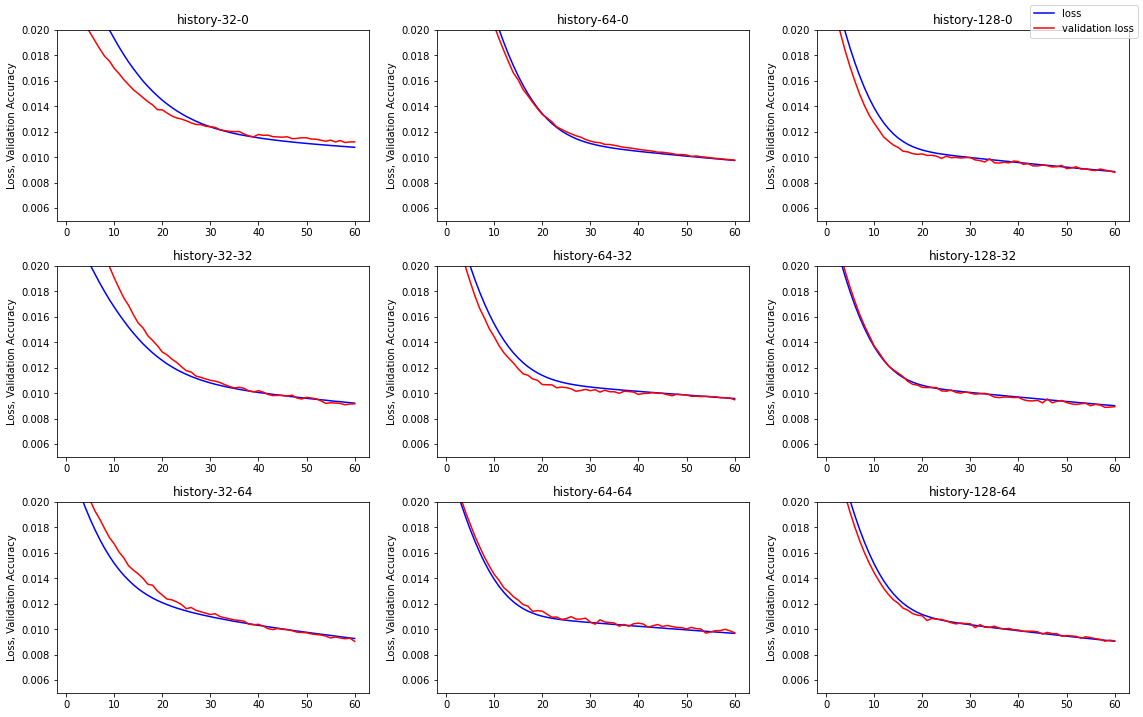

In [ ]:
plt.figure(figsize=(16,10))

index = 0
for I, p in enumerate(lstm_shape2):
  for J, o in enumerate(lstm_shape):
      # for p in batches:
  #   for o in lstm_shape:
  #     for l in lstm_shape2:
    index+=1
    l, v, _ = get_dicts8(2, o, p)
    x_labels = np.arange(1, len(v)+1)
    ax=plt.subplot(len(batches),len(lstm_shape),index)
    ax.set_title('history-'+str(o)+'-'+str(p))
    ax.plot(x_labels, l, c='b')
    ax.plot(x_labels, v, c='r')
    ax.set_ylabel('Loss, Validation Accuracy')
    # ax1=ax.twinx()
    ax.set_ylim(bottom=.005, top=.02)
    # ax1.set_ylim(bottom=.5, top=1)
    # ax1.plot(x_labels, f,c='lawngreen')
    # ax1.set_ylabel('Fit Accuracy')



plt.figlegend(labels = (  'loss', 'validation loss'), loc='best')
plt.tight_layout(pad=1.2)
plt.show()

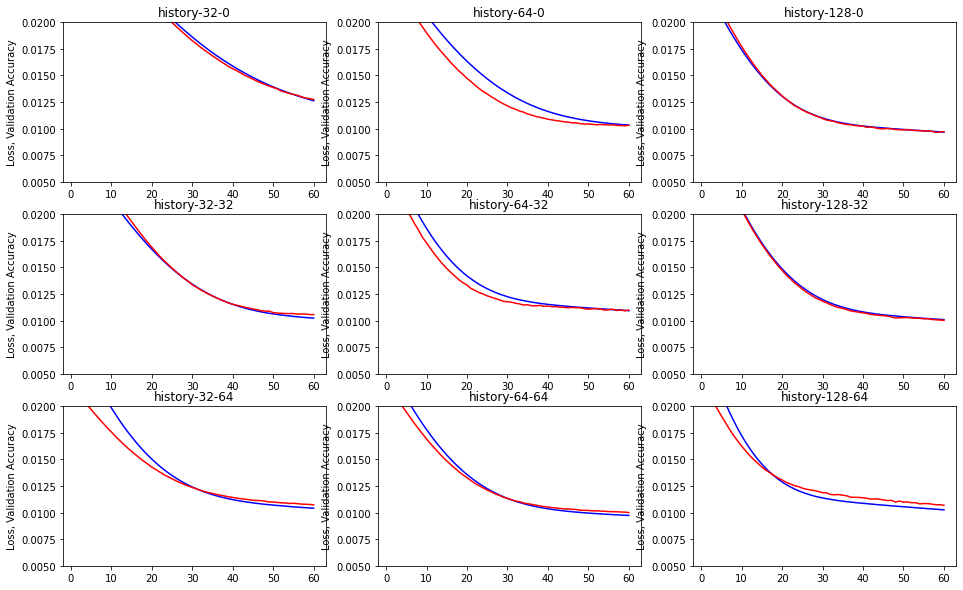

In [ ]:
plt.figure(figsize=(16,10))
index = 0
for I, p in enumerate(lstm_shape2):
  for J, o in enumerate(lstm_shape):
      # for p in batches:
  #   for o in lstm_shape:
  #     for l in lstm_shape2:
    index+=1
    l, v, _ = get_dicts8(4, o, p)
    x_labels = np.arange(1, len(v)+1)
    ax1=plt.subplot(len(batches),len(lstm_shape),index)
    ax1.set_title('history-'+str(o)+'-'+str(p))
    ax1.plot(x_labels, l, c='b')
    ax1.plot(x_labels, v, c='r')
    ax1.set_ylabel('Loss, Validation Accuracy')
    # ax1=ax.twinx()
    ax1.set_ylim(bottom=.005, top=.02)
    # ax1.set_ylim(bottom=.5, top=1)
    # ax1.plot(x_labels, f,c='lawngreen')
    # ax1.set_ylabel('Fit Accuracy')


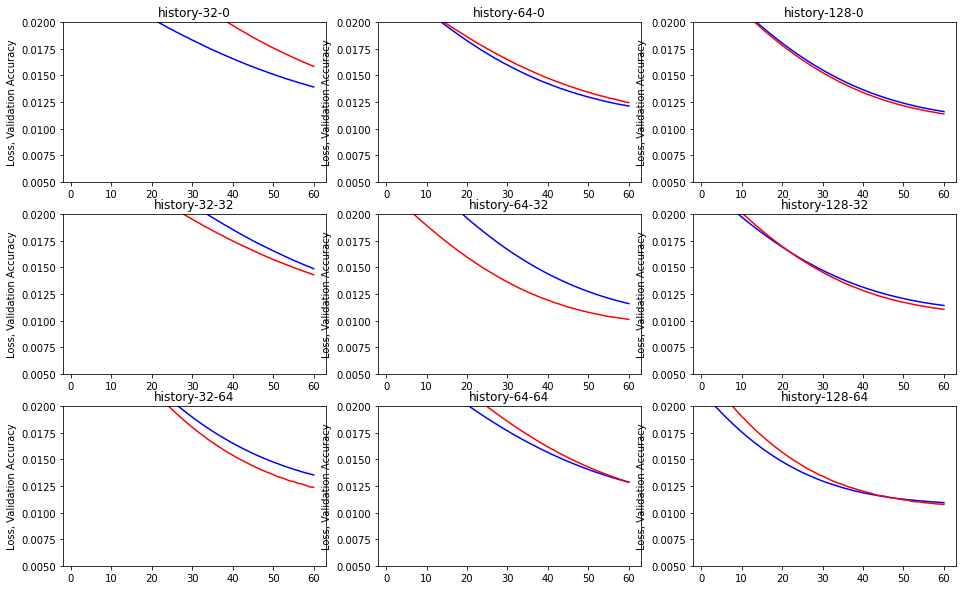

In [ ]:
plt.figure(figsize=(16,10))
index = 0
for I, p in enumerate(lstm_shape2):
  for J, o in enumerate(lstm_shape):
      # for p in batches:
  #   for o in lstm_shape:
  #     for l in lstm_shape2:
    index+=1
    l, v, _ = get_dicts8(8, o, p)
    x_labels = np.arange(1, len(v)+1)
    ax2=plt.subplot(len(batches),len(lstm_shape),index)
    ax2.set_title('history-'+str(o)+'-'+str(p))
    ax2.plot(x_labels, l, c='b')
    ax2.plot(x_labels, v, c='r')
    ax2.set_ylabel('Loss, Validation Accuracy')
    # ax1=ax.twinx()
    ax2.set_ylim(bottom=.005, top=.02)
    # ax1.set_ylim(bottom=.5, top=1)
    # ax1.plot(x_labels, f,c='lawngreen')
    # ax1.set_ylabel('Fit Accuracy')